In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
from tsforest.forecaster import LightGBMForecaster

import matplotlib.pyplot as plt
import seaborn as sns

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage, find_out_of_stock
from evaluation import WRMSSEEvaluator

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [3]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
weights_level12.head()   

,item_id,store_id,weight
0,1613,1,1.970000e-05
1,1613,2,1.850000e-05
2,1613,3,1.430000e-05
3,1613,4,5.380000e-06
4,1613,5,5.980000e-07


In [4]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["store_id","item_id"]).rename({"q":"s"}, axis=1)
scales.head()

,store_id,item_id,s
0,1,1,1.168326
1,1,2,0.782439
2,1,3,0.886355
3,1,4,2.681374
4,1,5,1.634013


In [5]:
#sigma = lambda x: (1/(1+np.exp(-x)))/0.7310585786300049
#weights = (weights_level12
#    .assign(weight = lambda x: sigma(x.weight/x.weight.median()))
#)
#weights.weight.describe()

In [6]:
#data = pd.merge(data, weights, how="left", on=["store_id","item_id"])

***

In [7]:
def find_out_of_stock(df, threshold=28):
    df = df.copy()
    df["no_stock"] = 0
    zero_mask = (df.y == 0)
    transition_mask = (zero_mask != zero_mask.shift(1))
    zero_sequences = transition_mask.cumsum()[zero_mask]
    idx = zero_sequences[zero_sequences.map(zero_sequences.value_counts()) >= threshold].index 
    df.loc[idx, "no_stock"] = 1
    return df

In [8]:
%%time
data.drop("no_stock", axis=1, inplace=True)
data = data.groupby(["item_id","store_id"]).apply(find_out_of_stock, threshold=28)
data.reset_index(drop=True, inplace=True)

CPU times: user 3min 53s, sys: 23.9 s, total: 4min 17s
Wall time: 4min 16s


***
### finding time series with few samples

In [9]:
ts_with_few_samples = (data
                       .groupby(["item_id","store_id"])["ds"]
                       .count()
                       .reset_index(name="n_samples")
                       .query("n_samples < 29")
)
ts_with_few_samples.head()

,item_id,store_id,n_samples


In [ ]:
few_samples_data = (data
                    .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
                    .query("_merge == 'both'")
                    .drop("_merge", axis=1)
                    .reset_index(drop=True)
                   )

In [6]:
data = (data
        .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
        .query("_merge == 'left_only'")
        .drop("_merge", axis=1)
        .reset_index(drop=True)
       )

***

In [9]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [10]:
#valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")), 
                 (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24"))]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')),
 (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
## training

In [11]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':200,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]


model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "lags": list(range(1,15)),
    "window_functions":["mean","std"],
    "window_sizes":[7,14,28,56],
    "exclude_features":["regular_price",
                        "ts_id",
                        "event_type_1",
                        "event_name_2",
                        "event_type_2"],
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

***
### Training validation models

In [12]:
# 5 years of history
train_history = 1825

############################################### 1/3 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.713137
[50]	valid_0's wrmsse: 0.649729
[75]	valid_0's wrmsse: 0.640338
[100]	valid_0's wrmsse: 0.637966
[125]	valid_0's wrmsse: 0.636762
[150]	valid_0's wrmsse: 0.636173
[175]	valid_0's wrmsse: 0.635835
[200]	valid_0's wrmsse: 0.635577
[225]	valid_0's wrmsse: 0.635377
[250]	valid_0's wrmsse: 0.635161
[275]	valid_0's wrmsse: 0.634968
[300]	valid_0's wrmsse: 0.634856
[325]	valid_0's wrmsse: 0.634722
[350]	valid_0's wrmsse: 0.634583
[375]	valid_0's wrmsse: 0.634556
[400]	valid_0's wrmsse: 0.634475
[425]	valid_0's wrmsse: 0.634353
[450]	valid_0's wrmsse: 0.634289
[475]	valid_0's wrmsse: 0.634169
[500]	valid

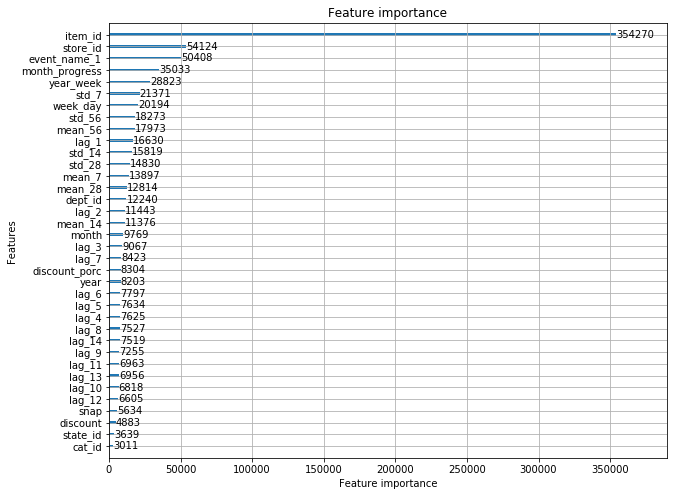

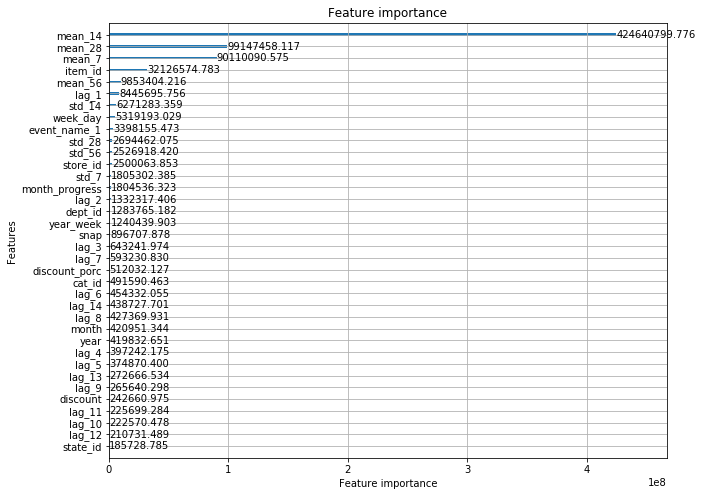

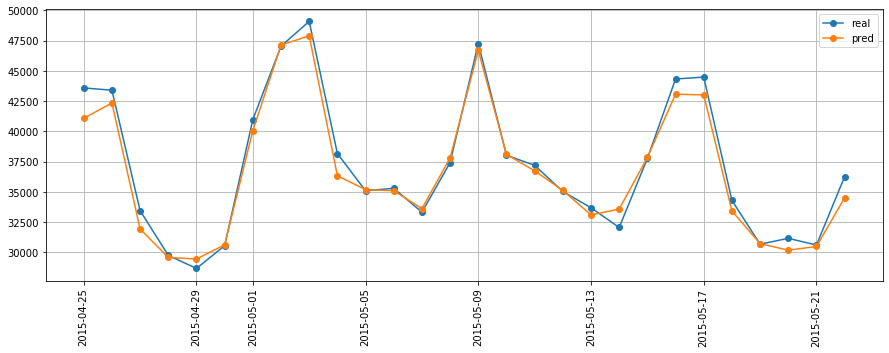

############################################### 2/3 ################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.735328
[50]	valid_0's wrmsse: 0.670682
[75]	valid_0's wrmsse: 0.660713
[100]	valid_0's wrmsse: 0.658243
[125]	valid_0's wrmsse: 0.657027
[150]	valid_0's wrmsse: 0.65629
[175]	valid_0's wrmsse: 0.65574
[200]	valid_0's wrmsse: 0.655479
[225]	valid_0's wrmsse: 0.655199
[250]	valid_0's wrmsse: 0.654919
[275]	valid_0's wrmsse: 0.654862
[300]	valid_0's wrmsse: 0.654742
[325]	valid_0's wrmsse: 0.654705
[350]	valid_0's wrmsse: 0.654638
[375]	valid_0's wrmsse: 0.654516
[400]	valid_0's wrmsse: 0.654416
[425]	valid_0's wrmsse: 0.654407
[450]	valid_0's wrmsse: 0.654357
[475]	valid_0's wrmsse: 0.654323
[500]	valid_0

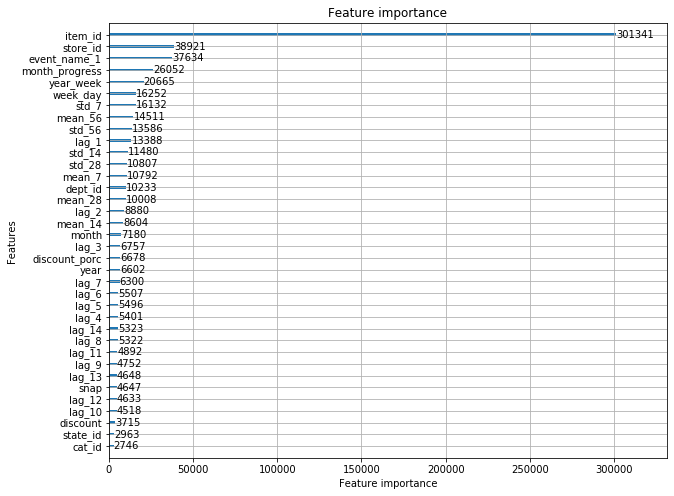

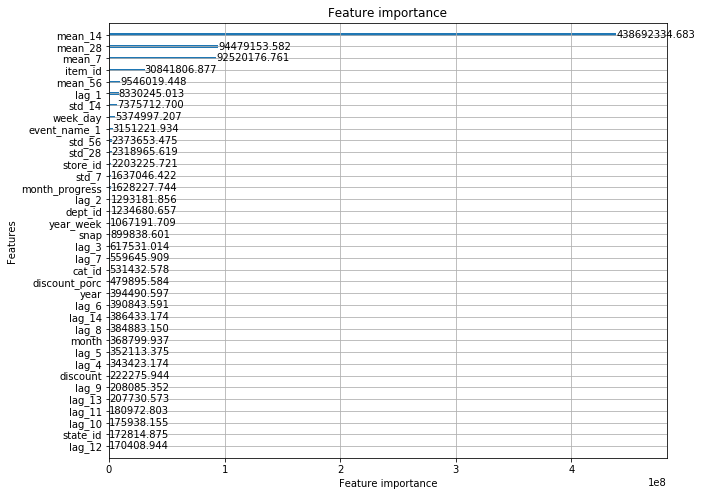

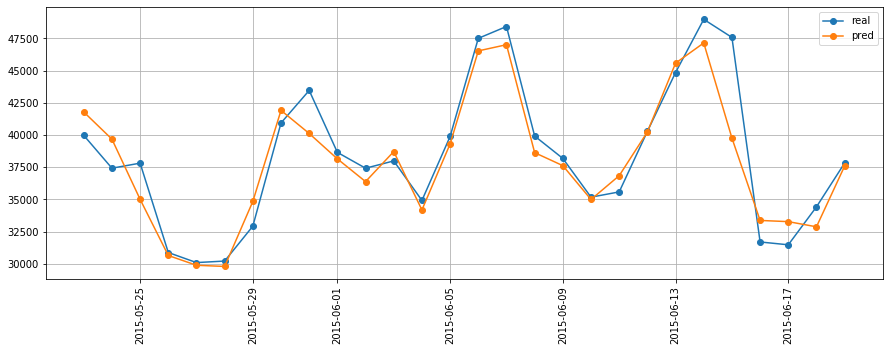

############################################### 3/3 ################################################
##### Validation period: (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.906223
[50]	valid_0's wrmsse: 0.830661
[75]	valid_0's wrmsse: 0.821303
[100]	valid_0's wrmsse: 0.819046
[125]	valid_0's wrmsse: 0.81762
[150]	valid_0's wrmsse: 0.816848
[175]	valid_0's wrmsse: 0.816582
[200]	valid_0's wrmsse: 0.816348
[225]	valid_0's wrmsse: 0.816182
[250]	valid_0's wrmsse: 0.816032
[275]	valid_0's wrmsse: 0.8158
[300]	valid_0's wrmsse: 0.815856
[325]	valid_0's wrmsse: 0.81588
[350]	valid_0's wrmsse: 0.815865
[375]	valid_0's wrmsse: 0.815705
[400]	valid_0's wrmsse: 0.815553
[425]	valid_0's wrmsse: 0.815438
[450]	valid_0's wrmsse: 0.815468
[475]	valid_0's wrmsse: 0.815443
[500]	valid_0's

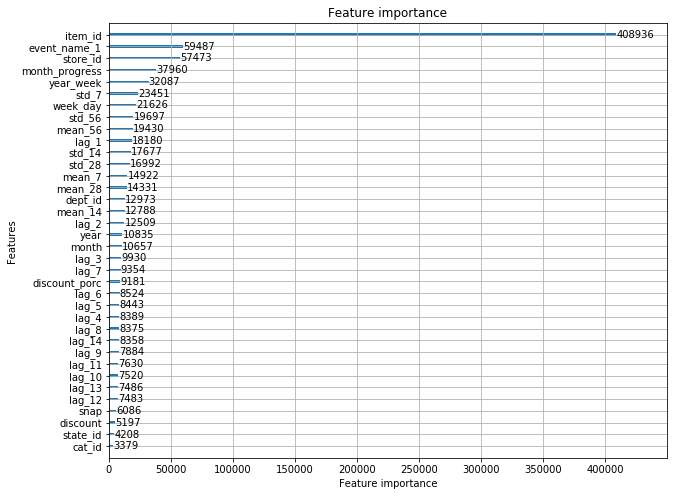

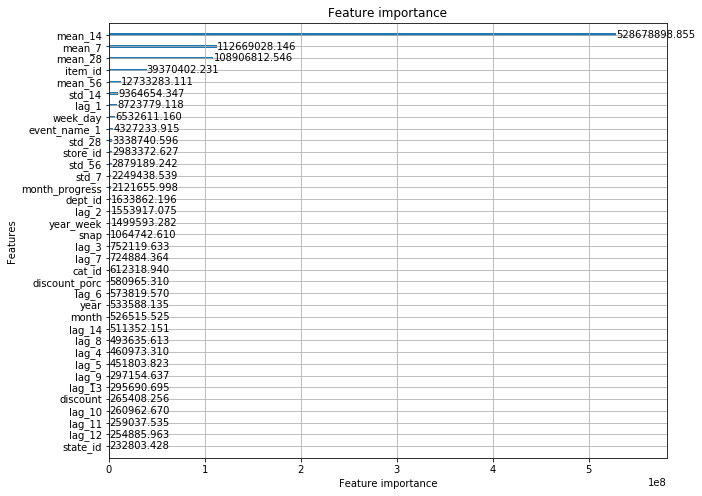

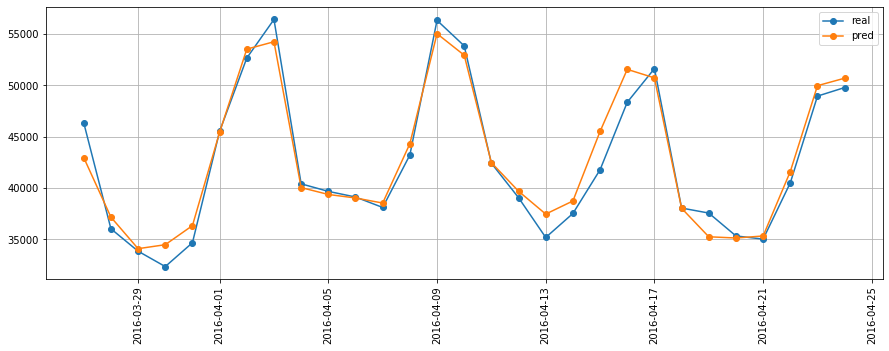

CPU times: user 2d 3h 17min 55s, sys: 4h 28min 29s, total: 2d 7h 46min 25s
Wall time: 3h 30min 4s


In [12]:
%%time

models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);
    _fcaster.train_features.dropna(inplace=True)
    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level12, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)
    
    # visualizing the predictions at level 1
    predictions = (_fcaster.valid_features
                   .loc[:, ["ds"]+_fcaster.ts_uid_columns]
                   .assign(y_pred = _fcaster.model.predict(_fcaster.valid_features))
                  )
    mrg =  (data.loc[:, ["ds","item_id","store_id","y"]]
            .merge(predictions, how="inner", on=["ds","item_id","store_id"]))
    df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()
    
    print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
    print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)
    
    plt.figure(figsize=(15,5))
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()

In [ ]:
[582]	valid_0's wrmsse: 0.813569
RMSE: 1420.1789307899646
RMSSE: 0.2396516853212219

In [15]:
int(np.mean(best_iterations))

802

In [14]:
np.mean(errors)

0.700956224023367

***
### final model

In [13]:
# 5 years of history
train_history = 1825

In [14]:
#model_kwargs["model_params"]["num_iterations"] = int(np.mean(best_iterations))
model_kwargs["model_params"]["num_iterations"] = 802
model_kwargs["model_params"]

{'objective': 'tweedie',
 'tweedie_variance_power': 1.1,
 'metric': 'None',
 'num_iterations': 802,
 'early_stopping_rounds': 200,
 'max_bin': 127,
 'bin_construct_sample_cnt': 6000000,
 'num_leaves': 1023,
 'min_data_in_leaf': 2047,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.66,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'seed': 7,
 'boost_from_average': False}

In [15]:
train_start = data.ds.max() - pd.DateOffset(days=train_history)
train_data = data.query("ds >= @train_start").reset_index(drop=True)

In [16]:
%%time
fcaster = LightGBMForecaster(**model_kwargs)
fcaster.prepare_features(train_data=train_data)

fcaster.train_features.dropna(inplace=True)
drop_idx = fcaster.train_features.query("no_stock == 1").index
fcaster.train_features.drop(drop_idx, axis=0, inplace=True)
fcaster.train_features = reduce_mem_usage(fcaster.train_features)

CPU times: user 12min 15s, sys: 7min 43s, total: 19min 59s
Wall time: 19min 58s


In [17]:
%%time
fcaster.fit(fit_kwargs={"verbose_eval":20})

CPU times: user 8h 19min 10s, sys: 37min 25s, total: 8h 56min 36s
Wall time: 28min 34s


In [18]:
%%time
fcaster.fit(fit_kwargs={"verbose_eval":20})

CPU times: user 14h 26min 41s, sys: 18min 33s, total: 14h 45min 14s
Wall time: 54min 5s


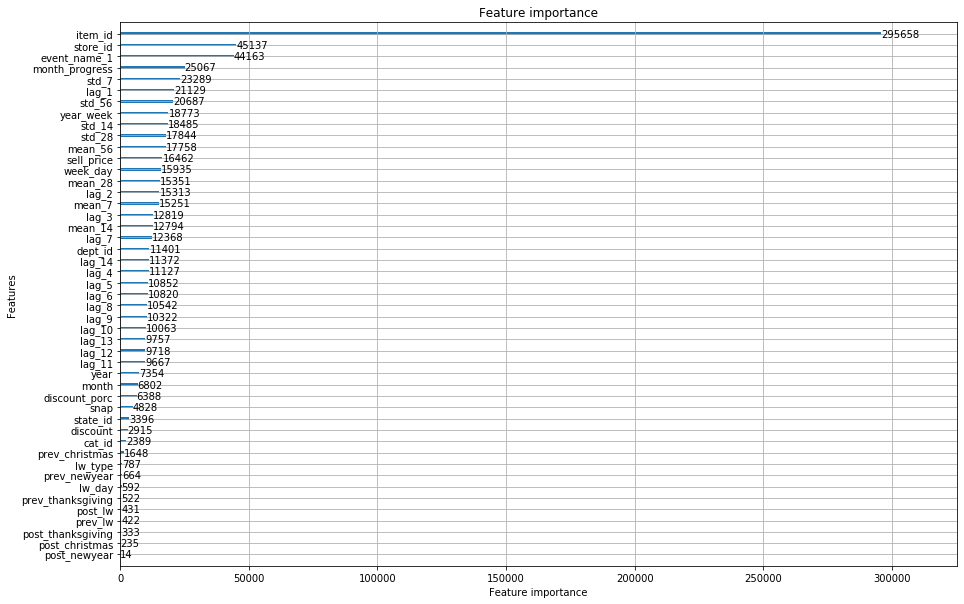

In [18]:
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));

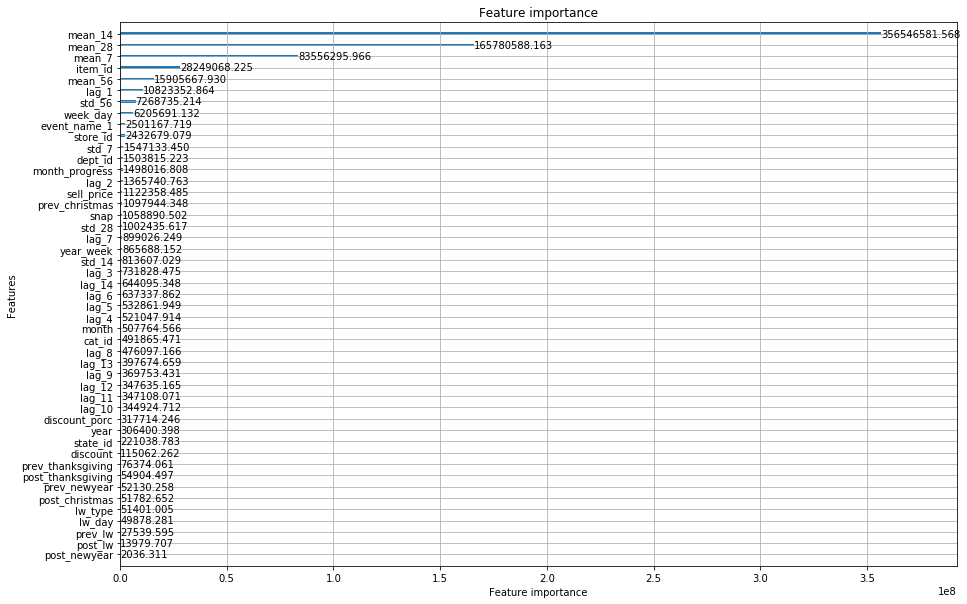

In [19]:
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
### estimating residuals

In [61]:
outfile = open("model.pkl", "wb")
pickle.dump(fcaster, outfile, protocol=4)
outfile.close()

In [2]:
model_file = open("model.pkl", "rb")
fcaster = pickle.load(model_file)
model_file.close()

In [ ]:
predict_columns = list(set(fcaster.train_data.columns) - {"y"})
predictions = fcaster.predict(fcaster.train_data.loc[:, predict_columns])

In [ ]:
residual_variance = (pd.merge(fcaster.train_data, predictions, how="inner", on=["item_id","store_id","ds"])
                     .assign(residual = lambda x: x.y - x.y_pred)
                     .groupby(["item_id","store_id"])["residual"].std()
                     .reset_index())
residual_variance

In [ ]:
residual_variance.to_parquet("../output/residuals_level12_v2.parquet", index=False)

In [ ]:
residual_variance

***
### predicting

In [20]:
valid_dataframe = pd.read_parquet("../input/valid_dataframe.parquet")
eval_dataframe = pd.read_parquet("../input/eval_dataframe.parquet")
hierarchy = pd.read_parquet("../input/hierarchy.parquet")
submission = pd.read_csv("../input/sample_submission.csv")

In [21]:
#valid_dataframe = pd.merge(valid_dataframe, weights, how="left")
#eval_dataframe = pd.merge(eval_dataframe, weights, how="left")

In [22]:
# if the ts has no sales in the past 4 weeks, will be marked as out-of-stock for the prediction period.
left_date = data.ds.max() - pd.DateOffset(days=28)
no_sales_ts = (data
               .query("ds >= @left_date")
               .groupby(["ts_id"])
               .filter(lambda x: np.all(x.y==0))
               .loc[:, ["ts_id"]]
               .drop_duplicates()
              )

In [23]:
valid_dataframe = valid_dataframe.query("ts_id not in @no_sales_ts.ts_id")

In [33]:
fcaster.input_features

['item_id',
 'store_id',
 'year',
 'month',
 'year_week',
 'week_day',
 'month_progress',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'mean_7',
 'mean_14',
 'mean_28',
 'mean_56',
 'std_7',
 'std_14',
 'std_28',
 'std_56',
 'dept_id',
 'cat_id',
 'state_id',
 'event_name_1',
 'sell_price',
 'discount',
 'discount_porc',
 'prev_christmas',
 'post_christmas',
 'prev_newyear',
 'post_newyear',
 'prev_thanksgiving',
 'post_thanksgiving',
 'lw_type',
 'lw_day',
 'prev_lw',
 'post_lw',
 'snap',
 'no_stock']

***

In [24]:
%%time
predictions = fcaster.predict(valid_dataframe, recursive=True);

CPU times: user 1h 11min 51s, sys: 2min 49s, total: 1h 14min 40s
Wall time: 59min 48s


In [25]:
%%time
predictions = fcaster.predict(valid_dataframe, recursive=True);

CPU times: user 1h 13min 49s, sys: 3min 4s, total: 1h 16min 54s
Wall time: 1h 1min 32s


***
### predictions for validation period

In [25]:
predictions_valid = pd.merge(predictions,
                             hierarchy.loc[:, ["id", "item_id", "store_id"]], 
                             how="left")
predictions_valid["id"] = predictions_valid.id.map(lambda x: x+"_validation")

In [26]:
predictions_valid.y_pred.describe()

count    810320.000000
mean          1.502087
std           3.110688
min           0.041540
25%           0.321589
50%           0.688371
75%           1.503889
max         190.862202
Name: y_pred, dtype: float64

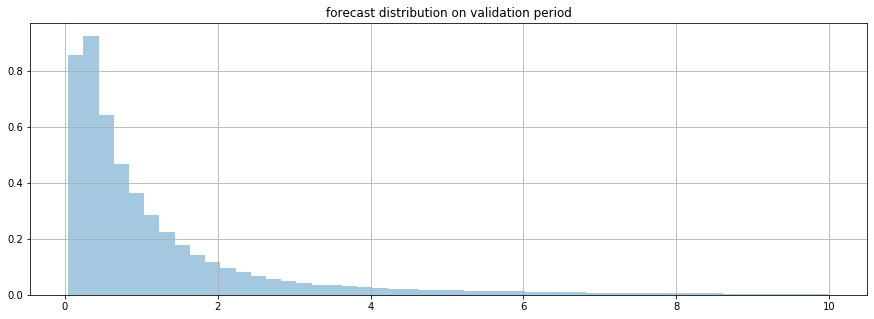

In [27]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_valid.query("y_pred < 10").y_pred.values, kde=False, norm_hist=True)
plt.title("forecast distribution on validation period")
plt.grid()

In [28]:
predictions_valid = (predictions_valid
                     .pivot(index="id", columns="ds", values="y_pred")
                     .reset_index()
                     )
predictions_valid.columns = ["id"] + [f"F{i}" for i in range (1,29)]

***
### predictions for evaluation period

(ommited for now)

***
### submission file

In [99]:
assert set(predictions_valid.id) == set(submission.loc[0:30489].id), \
    "there are missing time series predictions."

AssertionError: there are missing time series predictions.

In [29]:
submission = pd.merge(submission.loc[:, ["id"]], predictions_valid, how="left", on="id").fillna(0)

In [30]:
file_path = "../output/lgbm_bottom_v62.csv.gz"

if os.path.isfile(file_path):
    print("File already exists.")
else:
    submission.to_csv(file_path, index=False, compression="gzip")

In [31]:
!ls ../output

lgbm_bottom_v53.csv.gz	lgbm_bottom_v57.csv.gz	lgbm_bottom_v61.csv.gz
lgbm_bottom_v54.csv.gz	lgbm_bottom_v58.csv.gz	lgbm_bottom_v62.csv.gz
lgbm_bottom_v55.csv.gz	lgbm_bottom_v59.csv.gz
lgbm_bottom_v56.csv.gz	lgbm_bottom_v60.csv.gz


In [32]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../output/lgbm_bottom_v62.csv.gz -m ""

100%|██████████████████████████████████████| 7.09M/7.09M [00:03<00:00, 2.21MB/s]
Successfully submitted to M5 Forecasting - Accuracy

***